# Exercise 4 - Neural Networks Learning

This notebook covers my solutions to Andrew Ng's Machine Learning course Exercise 4 - Neural Networks Learning.

In this exercise, we implement a neural network to fit a non-linear hypothesis to the MNIST dataset. We implement the backpropagation algorithm to train the network .

First, import necessary packages:

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from scipy.io import loadmat
from sklearn.preprocessing import OneHotEncoder

# Initialise parameters
input_layer_size  = 400   # 20x20 Input Images of Digits
hidden_layer_size = 25    # 25 hidden units
num_labels = 10           # 10 labels, from 1 to 10   
                          # (note that we have mapped "0" to label 10)

Let's load and inspect the training data.

(-0.5, 399.5, 19.5, -0.5)

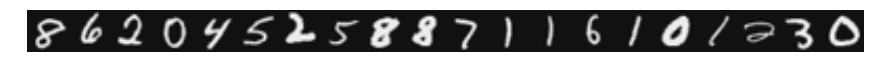

In [22]:
path = os.path.join(os.getcwd(), 'data', 'ex4data1.mat')
data = loadmat(path)
y = data['y']
X = data['X']

# Choose a random sample of data to display
sample = X[np.random.choice(X.shape[0], 20)]
plt.figure(figsize=(15,15))
plt.imshow(sample.reshape(-1, 20).T, interpolation='bilinear', cmap='gray')
plt.axis('off')

Now, we load some pre-initialised neural network parameters, and unroll the weights $\theta_1$, $\theta_2$ into a single parameter vector. Note that we first need to transpose the matrices to get MATLAB-like behaviour.

In [23]:
path2 = os.path.join(os.getcwd(), 'data', 'ex4weights.mat')
weights = loadmat(path2)
Theta1 = weights['Theta1']
Theta2 = weights['Theta2']
nn_params = np.r_[Theta1.T.ravel(), Theta2.T.ravel()]
print('Theta 1 shape: ', Theta1.shape, 
      '\nTheta 2 shape: ', Theta2.shape, 
      '\nUnrolled shape: ', nn_params.shape)

Theta 1 shape:  (25, 401) 
Theta 2 shape:  (10, 26) 
Unrolled shape:  (10285,)


## Compute Cost (Feedforward)
First, we define the cost function for the forward pass.

Again we use the sigmoid activation function.

In [101]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

First we need to implement the cost function for the feedforward part of the neural network, we can check this with the given expected values for the initial set of weights. The neural network cost function is given by:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K\bigg[-y_k^{(i)}\text{log}(h_\theta(x^{(i)})_k) - (1-y_k^{(i)})\text{log}(1-h_\theta(x^{(i)})_k)\bigg]$$

We can use a for loop over the training examples $m$.

In [115]:
def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    
    # Reshape the parameters back into matrix form
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, input_layer_size+1, order='F')
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, hidden_layer_size+1, order='F')
    
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    # Convert labels to binary form
    onehot_encoder = OneHotEncoder(sparse=False)
    y_binary = onehot_encoder.fit_transform(y)
    
    # Compute forward pass
    X = np.insert(X, 0, 1, axis=1)
    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.insert(a2, 0, 1, axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    h = a3
    
    # Loop over training examples
    for i in range(m):
        first = - y_binary[i,:] * np.log(h[i,:])
        second = (1 - y_binary[i,:]) * np.log(1 - h[i,:])
        J += np.sum(first - second)
    
    return J / m

Let's first test the cost function without regularisation and compare with the expected value.

In [106]:
cost = nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, 0)
print('Cost: ', cost, '\nExpected Cost: 0.287629')

Cost:  0.2876291651613187 
Expected Cost: 0.287629


Now let's add the regularisation term. The cost function with regularisation is given by:

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K\bigg[-y_k^{(i)}\text{log}(h_\theta(x^{(i)})_k) - (1-y_k^{(i)})\text{log}(1-h_\theta(x^{(i)})_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{\Theta^{(1)}_{rows}}\sum_{k=1}^{\Theta^{(1)}_{cols}}(\Theta^{(1)}_{j,k})^2 + \sum_{j=1}^{\Theta^{(2)}_{rows}}\sum_{k=1}^{\Theta^{(2)}_{cols}}(\Theta^{(2)}_{j,k})^2\bigg]$$

We must define code that generalises to any shape of hidden layers, input layers and class number. Note that we do not regularise the bias term so this should be removed from $\theta_{1,2}$.

In [129]:
def nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg):
    
    # Reshape the parameters back into matrix form
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape(hidden_layer_size, input_layer_size+1, order='F')
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape(num_labels, hidden_layer_size+1, order='F')
    
    m = X.shape[0]
    J = 0
    theta1_grad = np.zeros(theta1.shape)
    theta2_grad = np.zeros(theta2.shape)
    
    # Convert labels to binary form
    onehot_encoder = OneHotEncoder(sparse=False)
    y_binary = onehot_encoder.fit_transform(y)
    
    # Compute forward pass
    X = np.insert(X, 0, 1, axis=1)
    a2 = sigmoid(X.dot(Theta1.T))
    a2 = np.insert(a2, 0, 1, axis=1)
    a3 = sigmoid(a2.dot(Theta2.T))
    h = a3
    
    # Loop over training examples
    for i in range(m):
        first = - y_binary[i,:] * np.log(h[i,:])
        second = (1 - y_binary[i,:]) * np.log(1 - h[i,:])
        J += np.sum(first - second)
        
    reg_term = reg / (2 * m) * (np.sum(theta1[:,1:] ** 2) + np.sum(theta2[:,1:] ** 2))
    
    return J / m + reg_term

Now, let's test the cost function with regularisation implemented against the expected value.

In [130]:
reg = 1
cost = nnCostFunctionReg(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, reg)
print('Cost w/ reg: ', cost, '\nExpected Cost: 0.383770')

Cost w/ reg:  0.3837698590909234 
Expected Cost: 0.383770


## Backpropagation
First, we must implement the sigmoid gradient function given by:

$$ \frac{d}{dz}g(z) = g(z)(1 - g(z))$$

In [131]:
def grad_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))